# Monte Carlo Integration

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gamma, cauchy, uniform, norm
from scipy.special import loggamma
from scipy.integrate import quad 
import scipy
import matplotlib.pyplot as plt

In [2]:
np.random.seed(3)

##### Example 3.1 and Figure 3.1

loggamma (lgamma in R) function returns the natural logarithm of the absolute value of gamma function (log gamma function) of the argument. The log gamma function of x is defined as:

$\Gamma(\lambda) = \ln \big | \int_{0}^{\infty} x^{\lambda-1} \exp (-x) \mathrm{d} x \big |$

In [3]:
lambda_values = np.linspace(0.01, 10, 100)

In [4]:
def gamma_fun(x, lambda_value):
    return x**(lambda_value-1)*np.exp(-x)
def integral_on_gamma(lambda_value):
    return quad(gamma_fun, 0, np.inf, args = lambda_value)[0]

In [5]:
gamma_integrals = np.vectorize(integral_on_gamma)(lambda_values)
scipy_loggamma = loggamma(lambda_values)

Text(0.5, 1.0, 'Integrate.quad function VS direct log-gamma calculation')

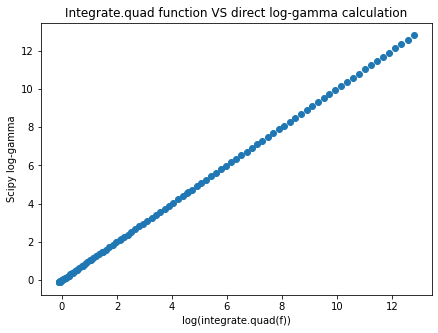

In [6]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x = np.log(gamma_integrals), y = scipy_loggamma)
ax.set_xlabel('log(integrate.quad(f))')
ax.set_ylabel('Scipy log-gamma')
ax.set_title('Integrate.quad function VS direct log-gamma calculation')

##### Example 3.2 and Figure 3.2 pag.63,64

This is not clear at all to me

In [7]:
def cauchy_product(the, cauchy_rvs):
    u = 1
    for i in range(10):
        u = u*cauchy.pdf(cauchy_rvs[1] - the) #why the theta is subtracted like this? In the formula (pag. 36) is under a quadratic operation 
    return u

In [8]:
cauchy_rvs = cauchy.rvs(size=10, loc = 350) 
quad(cauchy_product, -np.inf, np.inf, args = cauchy_rvs) #which should be the real value?

(6.471290919079487e-44, 1.2794160657758293e-43)

In [9]:
x = np.linspace(1, 10**3, 50)
y = []
for a in x:
    y.append(quad(cauchy_product, -a, a, args = cauchy_rvs)[0])

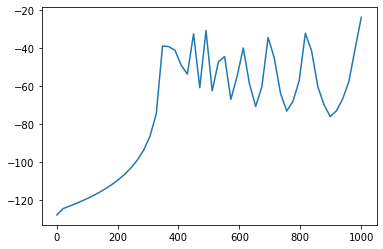

In [10]:
plt.plot(x, np.log(np.array(y)))

##### Example 3.3 and Figure 3.3 pag.65,66,67

In [11]:
def h(x):
    return (np.cos(50*x)+np.sin(20*x))**2
quad(h, 0, 1)

(0.9652009360501453, 1.8542214725442152e-10)

In [12]:
Nsim = 10**4
x = h(uniform.rvs(size=Nsim))

In [13]:
estint = np.cumsum(x)/np.arange(1,Nsim+1)
print("Monte Carlo approximation: {}".format(estint[-1]))
esterr = np.sqrt(np.cumsum(x - estint)**2/(np.arange(1,Nsim+1)**2))

Monte Carlo approximation: 0.9677351205717744


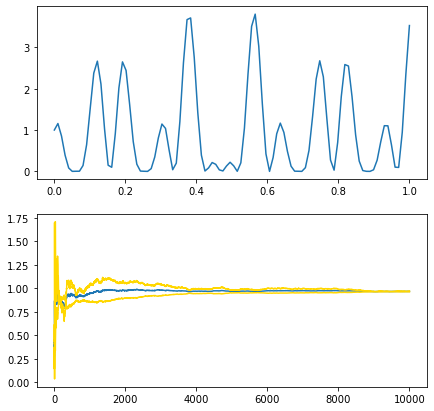

In [14]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(7,7))
ax1.plot(np.linspace(0, 1, 100), h(np.linspace(0, 1, 100)))

ax2.plot(np.arange(Nsim), estint)
ax2.plot(np.arange(Nsim), estint - 2*esterr, color ='gold')
ax2.plot(np.arange(Nsim), estint + 2*esterr, color ='gold')

##### Example 3.4

In [15]:
bound = norm.ppf([0.5, 0.75, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999]) #bound values are what in the formula is called t   

In order to calculate the number of simulations I need to obtain a certain digit round precision, I have to do some calculus. First, as said (pag. 68), the exact variance is 

$\Phi(t)[1-\Phi(t)] / n$

Since this is a decreasing function (for a fixed n) for t = 0, 1, 2, ... (you can check empirically), the maximum variance is when t = 0. For  t = 0, the variance is thus approximately 
$$
\Phi(0)* (1-\Phi(0)) /n \\
0.5*(1-0.5)/n \\
0.25/n
$$

In order to achieve a precision of four decimals, at a 95% confidence interval, we want that 2*standard_error, is smaller than 0.0001 i.e.:

$$
2*\sqrt{0.25/n} \leq 10^{-4} \\
n = 10^8
$$

In general, n (the number of simulations needed) can be calculated like this:

$$
2*\sqrt{\Phi(t)* (1-\Phi(t)) /n} \leq 10^{-k}\\
\frac{\Phi(t)* (1-\Phi(t))}{n} = \frac{10^{-2k}} {4}\\
\frac{n}{\Phi(t)* (1-\Phi(t))} = 4* 10^{2k}\\
n = 4* 10^{2k}*{\Phi(t)* (1-\Phi(t))}\\
n = 4* 10^{2k}*0.25 \\
\text{the above formula is because the maximum variance is when t = 0}\\
n = 10^{2k} \\
$$

where k is the number of digits I want to be precise

In [16]:
k = 4

Nsim = 10**(2*k)
x = norm.rvs(size = Nsim) #whole sample

In [17]:
diz = {}
digit_round = 4
for i in range(2,2*k+1): #lengthy loop
    for j in range(len(bound)):
        nsim = 10**i
        t = bound[j]
        mc_estimation = np.mean(x[1:nsim] < t)
        d = {t: mc_estimation}
        if nsim in diz.keys():
            diz[nsim].update(d) 
        else:
            diz[nsim] = d
table3_1 = pd.DataFrame.from_dict(diz, 'index')

In [18]:
table3_1

,0.000000,0.674490,0.841621,1.281552,1.644854,2.326348,3.090232,3.719016
100,0.595960,0.777778,0.797980,0.878788,0.949495,0.979798,1.000000,1.000000
1000,0.496496,0.741742,0.796797,0.889890,0.949950,0.988989,0.998999,1.000000
10000,0.496350,0.755076,0.805781,0.899090,0.952195,0.991999,0.999200,0.999900
100000,0.500075,0.752788,0.802318,0.900249,0.949449,0.990470,0.998990,0.999890
1000000,0.499336,0.749875,0.799864,0.899584,0.949977,0.990070,0.999017,0.999907
10000000,0.499735,0.749942,0.799924,0.899986,0.949969,0.989961,0.999001,0.999898
100000000,0.499972,0.749915,0.799937,0.899988,0.949997,0.990002,0.998997,0.999898


##### Exercise 3.1 pag.66

##### Exercise 3.2 pag.69

##### Exercise 3.3 pag.69